In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# model parameters
dt = 1 # time step [s]
N = 4 # number of sections in the collumn
T = 5 # total simulation time steps

# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 4 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
# process operation parameters
v = 1.0 # air speed [m/s]
V_liq = 0.5 # liquid sorbent volume [L]

In [3]:
# derived parameters
l_N = l/N # length of one section [m]
V_N = l_N # volume of one section [m^3]
ds = v * dt / l_N # number of sections (that air travels in one time step)
ds_int_flag = ds.is_integer() # flag if ds is integer
#p = 2 # number of sections before inlet (for airspeeds larger than l_N/dt) -> could be set to np.ceil(ds)
p = int(np.ceil(ds)) # number of sections before inlet (for airspeeds larger than l_N/dt)
if ds_int_flag:
    print(f"ds = {ds} is integer.")
print(f"ds: {ds} [segments per timesteps], -> p: {p} [segments before inlet]")

# concentration matrix
x = np.ones((T, N+p)) * np.nan # [Pa]. rows: time steps; collumns: sections

# set initial and boundary conditions: 
# 1) x = 40 Pa for all time steps(=rows) at inlet (p initial sections=columns);
x[:, 0:p] = 40 # initial concentration in inlet [Pa]
# 2) x = 40 Pa at t=0 for all sections:columns
x[0, :] = 40 # initial concentration in collumn [Pa]
x

# mol in gase phase matrix (mol per time step and section)
n = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections
# uptake matrix (mol per time step and section)
n2l = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections

# total uptake (over time)
n_total_t = np.zeros(T) # total uptake per time step [mol]

ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [segments before inlet]


In [4]:
x

array([[40., 40., 40., 40., 40.],
       [40., nan, nan, nan, nan],
       [40., nan, nan, nan, nan],
       [40., nan, nan, nan, nan],
       [40., nan, nan, nan, nan]])

In [5]:
def K_eff(uptake, K_initial, cap, V_liq):
    """Calculate effective mass transfer coefficient based on current uptake.
    
    Args:
        uptake (float): Current uptake in mol.
        K_initial (float): Initial mass transfer coefficient in mmol/(m^2 s kPa).
        cap (float): Cyclic uptake capacity in mol/L.
        V_liq (float): Liquid sorbent volume in L.
        N (int): Number of sections in the column.
        
    Returns:
        float: Effective mass transfer coefficient in mmol/(m^2 s kPa).
    """
    if uptake >= cap * V_liq:
        return 0.0
    else:
        return K_initial * (1 - uptake / (cap * V_liq))

In [6]:
x

array([[40., 40., 40., 40., 40.],
       [40., nan, nan, nan, nan],
       [40., nan, nan, nan, nan],
       [40., nan, nan, nan, nan],
       [40., nan, nan, nan, nan]])

In [7]:
for t in range(0, T):
    print(f"t = {t}")
    # 1) calculate uptake n for section i at time step t
    n2l[t, :] = x[t,p:N+p] * K_initial * 1e-6 * SSA * l_N * dt # uptake gas molecules to liquid [mol]
    print(f"n2l = {n2l}")
    n[t, :] = x[t,p:N+p] * V_N / (8.314 * 298) - n2l[t, :]# remaining in gas phase [mol]
    if (n[t, :] < 0.0).any(): # check if remaining in gas phase is negative
        print(f"Warning: negative remaining in gas phase! setting to zero. time step: {t}, index: {np.where(n[t, :] < 0.0)}")
        n2l[t, n[t, :] < 0.0] = x[t,p:N+p][n[t, :] < 0.0] * V_N / (8.314 * 298) # limit uptake to remaining in gas phase
        n[t, n[t, :] < 0.0] = 0.0
    #n2l[t, :] = x[t,p:N+p] * K_initial * 1e-6 * SSA * l_N * dt * 44 # uptake [g_co2]

    # 2) calc remaining concentration after uptake:
    x[t, p:N+p] = n[t, :] * 8.314 * 298 / (V_N) # new concentration [Pa]
    print(f"calculated remaind partial pressure in gasphase (at end of timestep {t}): {x[t, p:N+p]}")

    if t < T - 1:
        # 3) calc next concentration x for all sections (p:N+p) at time step t+1
        if ds_int_flag:# if ds is int(ds)
            x[t+1, p:N+p] = x[t, (p-int(ds)):(N+p-int(ds))] # new concentration (in next time step) equals the one 

        





t = 0
n2l = [[0.0126 0.0126 0.0126 0.0126]
 [   nan    nan    nan    nan]
 [   nan    nan    nan    nan]
 [   nan    nan    nan    nan]
 [   nan    nan    nan    nan]]
calculated remaind partial pressure in gasphase (at end of timestep 0): [8.7825928 8.7825928 8.7825928 8.7825928]
t = 1
n2l = [[0.0126     0.0126     0.0126     0.0126    ]
 [0.0126     0.00276652 0.00276652 0.00276652]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]]
calculated remaind partial pressure in gasphase (at end of timestep 1): [8.7825928  1.92834841 1.92834841 1.92834841]
t = 2
n2l = [[0.0126     0.0126     0.0126     0.0126    ]
 [0.0126     0.00276652 0.00276652 0.00276652]
 [0.0126     0.00276652 0.00060743 0.00060743]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]]
calculated remaind partial pressure in gasphase (at end of timestep 2): [8.7825928  1.92834841 0.4233974

In [8]:
x

array([[40.        ,  8.7825928 ,  8.7825928 ,  8.7825928 ,  8.7825928 ],
       [40.        ,  8.7825928 ,  1.92834841,  1.92834841,  1.92834841],
       [40.        ,  8.7825928 ,  1.92834841,  0.42339747,  0.42339747],
       [40.        ,  8.7825928 ,  1.92834841,  0.42339747,  0.09296319],
       [40.        ,  8.7825928 ,  1.92834841,  0.42339747,  0.09296319]])

In [9]:
n2l

array([[0.0126    , 0.0126    , 0.0126    , 0.0126    ],
       [0.0126    , 0.00276652, 0.00276652, 0.00276652],
       [0.0126    , 0.00276652, 0.00060743, 0.00060743],
       [0.0126    , 0.00276652, 0.00060743, 0.00013337],
       [0.0126    , 0.00276652, 0.00060743, 0.00013337]])

## some testing

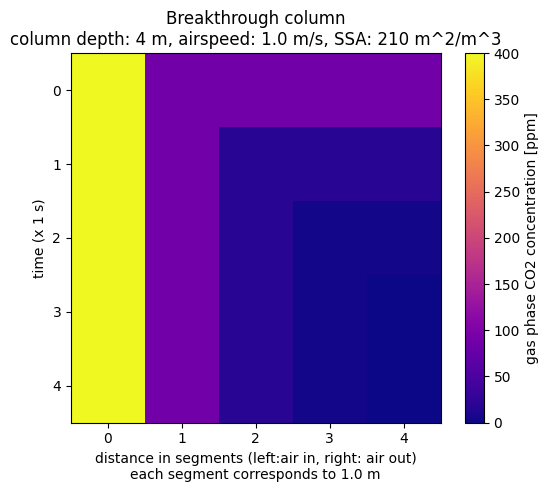

In [10]:

# Example matrix (values between 0 and 40)
#x = np.random.uniform(0, 40, size=(10, 10))

# Define custom colormap: 0 -> blue, 40 -> yellow
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])

plt.imshow(x[:,:]*10, cmap="plasma", vmin=0, vmax=400, interpolation="nearest")
plt.colorbar(label="gas phase CO2 concentration [ppm]")
plt.title(f"Breakthrough column\ncolumn depth: {l} m, airspeed: {v} m/s, SSA: {SSA} m^2/m^3")
plt.ylabel(f"time (x {dt} s)")
plt.xlabel(f"distance in segments (left:air in, right: air out)\neach segment corresponds to {l_N} m")
plt.show()


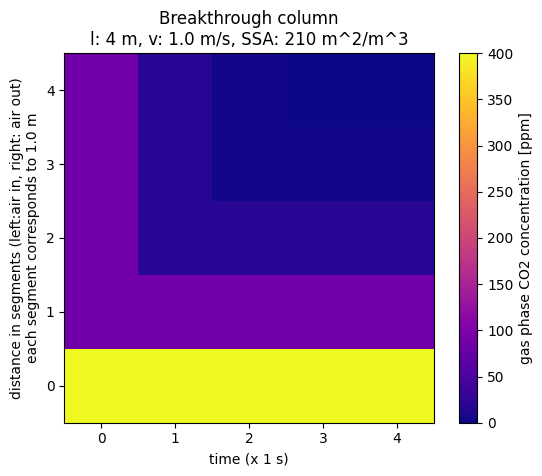

In [11]:

# Example matrix (values between 0 and 40)
#x = np.random.uniform(0, 40, size=(10, 10))

# Define custom colormap: 0 -> blue, 40 -> yellow
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])

plt.imshow(x[:,:].T*10, cmap="plasma", vmin=0, vmax=400, interpolation="nearest", origin="lower")
plt.colorbar(label="gas phase CO2 concentration [ppm]")
plt.title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m^2/m^3")
plt.xlabel(f"time (x {dt} s)")
plt.ylabel(f"distance in segments (left:air in, right: air out)\neach segment corresponds to {l_N} m")
plt.show()


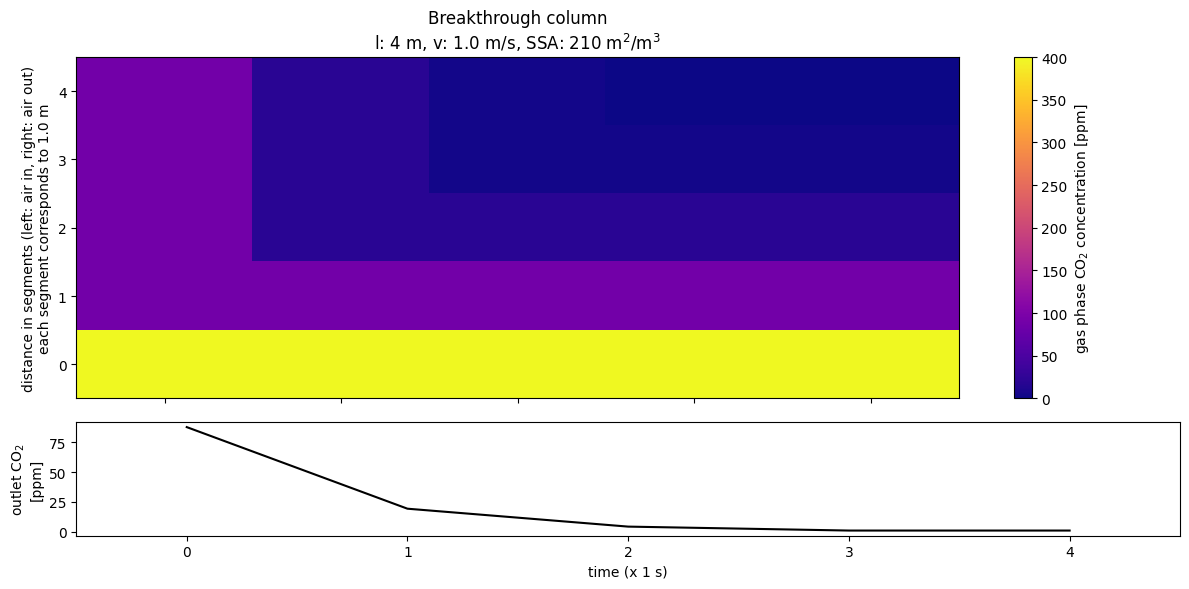

In [12]:


# Example dimensions / dummy data
#l, v, SSA, dt, l_N = 1.0, 0.1, 500, 1, 0.05
#x = np.random.uniform(0, 40, size=(100, 20))  # (time, position)

# Custom colormap if you want it
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6),  # wide, not too tall
    gridspec_kw={'height_ratios': [3, 1]},  # upper plot taller
    sharex=True
)

# --- Upper subplot: heatmap ---
im = ax1.imshow(
    x[:,:].T * 10, 
    cmap="plasma", vmin=0, vmax=400,
    interpolation="nearest", origin="lower", aspect="auto"
)
cbar = fig.colorbar(im, ax=ax1, label="gas phase CO$_2$ concentration [ppm]")
ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
ax1.set_ylabel(f"distance in segments (left: air in, right: air out)\n"
               f"each segment corresponds to {l_N} m")

# --- Lower subplot: outlet profile ---
ax2.plot(x[:, -1]*10, color="black")
ax2.set_xlabel(f"time (x {dt} s)")
ax2.set_ylabel("outlet CO$_2$\n[ppm]")

plt.tight_layout()
plt.show()


C:\Users\bebu\AppData\Local\Temp\ipykernel_26324\2164550224.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


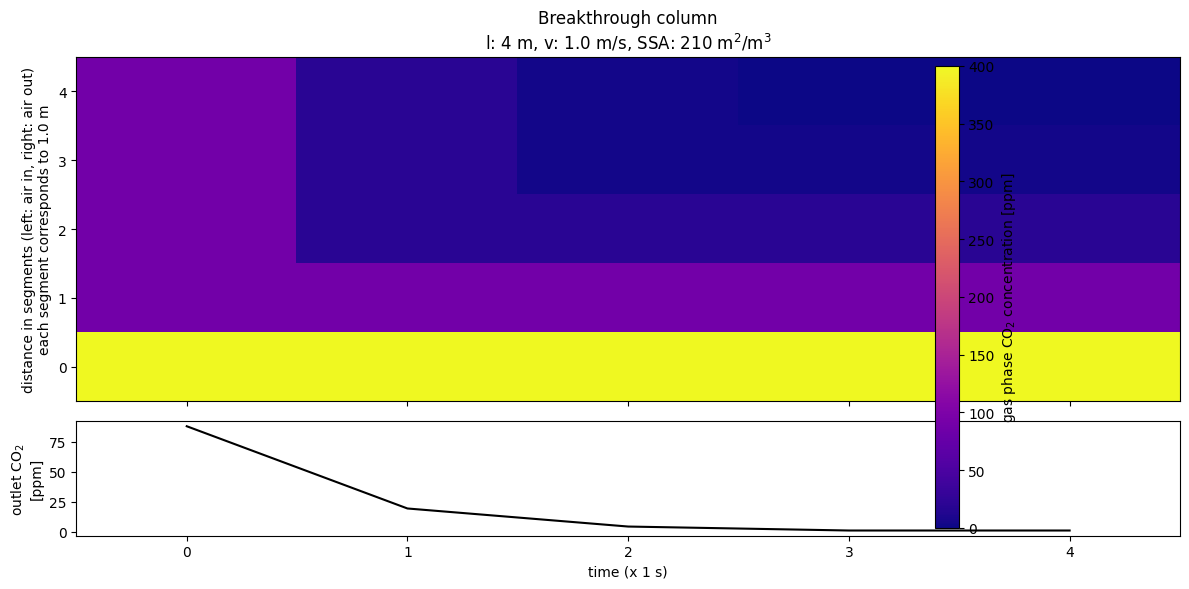

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Custom colormap if you want it
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

# --- Upper subplot: heatmap ---
im = ax1.imshow(
    x[:,:].T * 10, 
    cmap="plasma", vmin=0, vmax=400,
    interpolation="nearest", origin="lower", aspect="auto"
)
ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
ax1.set_ylabel(f"distance in segments (left: air in, right: air out)\n"
               f"each segment corresponds to {l_N} m")

# --- Lower subplot: outlet profile ---
ax2.plot(x[:, -1]*10, color="black")
ax2.set_xlabel(f"time (x {dt} s)")
ax2.set_ylabel("outlet CO$_2$\n[ppm]")

# --- Shared colorbar for both subplots ---
cbar = fig.colorbar(im, ax=[ax1, ax2], label="gas phase CO$_2$ concentration [ppm]")

plt.tight_layout()
plt.show()


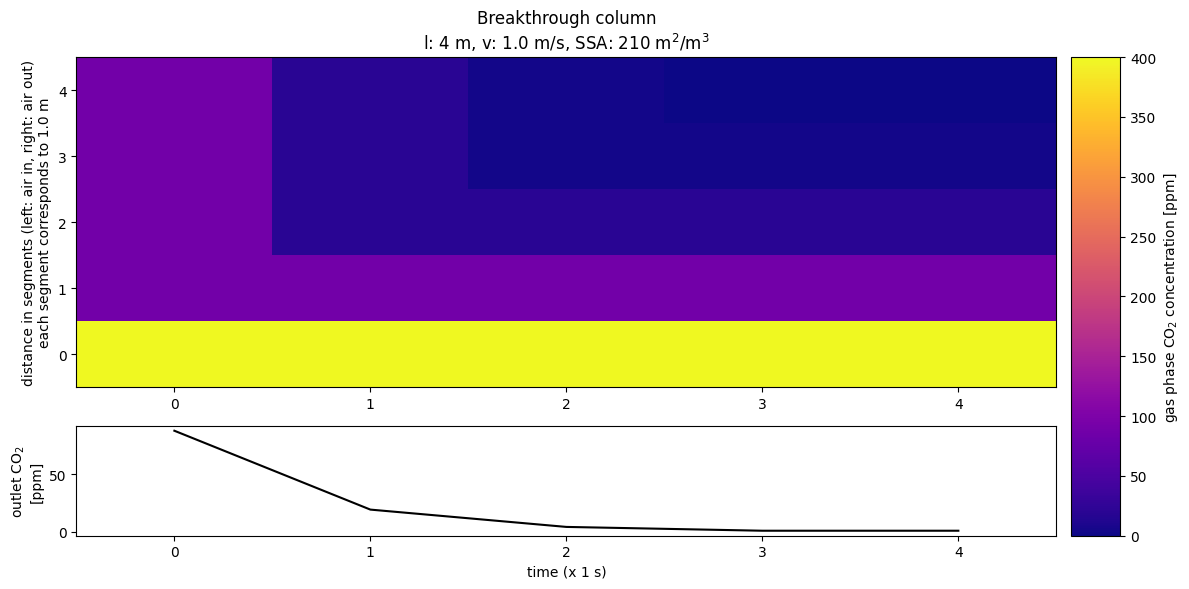

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Custom colormap if you want it
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])

# --- Figure with GridSpec: 2 rows, 2 cols ---
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, 0])   # heatmap
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # outlet profile
cax = fig.add_subplot(gs[:, 1])   # colorbar, spans both rows

# --- Upper subplot: heatmap ---
im = ax1.imshow(
    x[:,:].T * 10, 
    cmap="plasma", vmin=0, vmax=400,
    interpolation="nearest", origin="lower", aspect="auto"
)
ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
ax1.set_ylabel(f"distance in segments (left: air in, right: air out)\n"
               f"each segment corresponds to {l_N} m")

# --- Lower subplot: outlet profile ---
ax2.plot(x[:, -1]*10, color="black")
ax2.set_xlabel(f"time (x {dt} s)")
ax2.set_ylabel("outlet CO$_2$\n[ppm]")

# --- Colorbar ---
fig.colorbar(im, cax=cax, label="gas phase CO$_2$ concentration [ppm]")

plt.tight_layout()
plt.show()


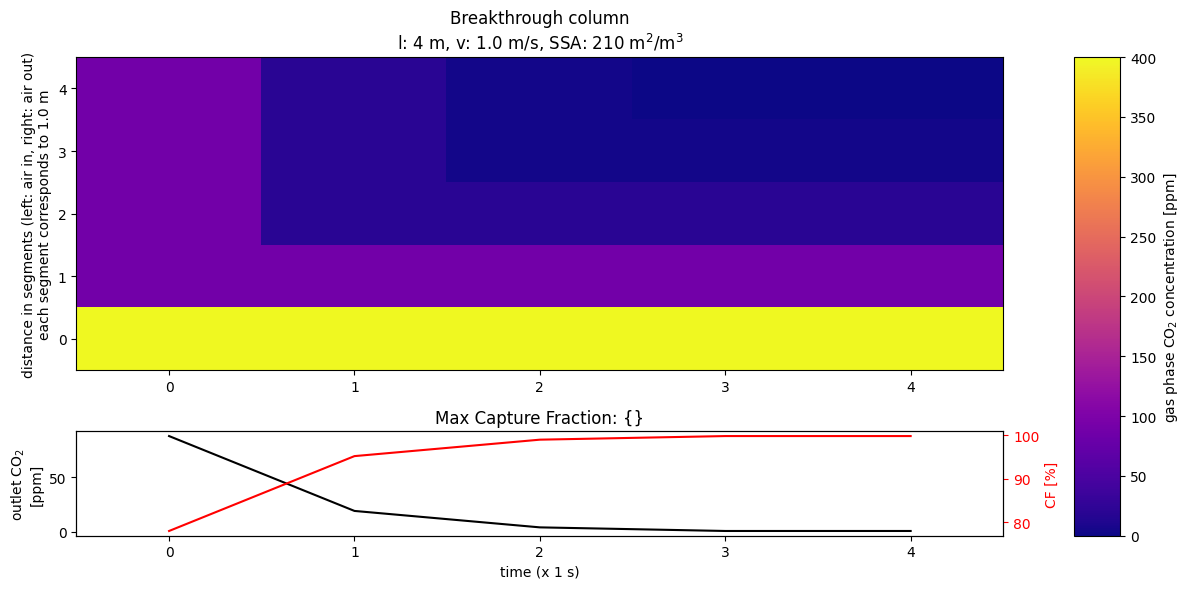

In [15]:


# Custom colormap
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])

# --- Figure with GridSpec: 2 rows, 2 cols ---
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, 0])          # heatmap
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # outlet profile
cax = fig.add_subplot(gs[:, 1])          # colorbar

# --- Upper subplot: heatmap ---
im = ax1.imshow(
    x[:,:].T * 10, 
    cmap="plasma", vmin=0, vmax=400,
    interpolation="nearest", origin="lower", aspect="auto"
)
ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
ax1.set_ylabel(f"distance in segments (left: air in, right: air out)\n"
               f"each segment corresponds to {l_N} m")

# --- Lower subplot: outlet profile ---
ax2.set_title("Max Capture Fraction: {}")
line1, = ax2.plot(x[:, -1]*10, color="black", label="outlet CO$_2$")
ax2.set_xlabel(f"time (x {dt} s)")
ax2.set_ylabel("outlet CO$_2$\n[ppm]", color="black")

# Second y-axis for CF [%]
ax2b = ax2.twinx()
cf = (400 - x[:, -1]*10) / 4   # scale to [%]
line2, = ax2b.plot(cf, color="red", label="CF")
ax2b.set_ylabel("CF [%]", color="red")

# Optional: match colors of axis labels to lines
ax2.tick_params(axis='y', colors=line1.get_color())
ax2b.tick_params(axis='y', colors=line2.get_color())

# --- Colorbar ---
fig.colorbar(im, cax=cax, label="gas phase CO$_2$ concentration [ppm]")

plt.tight_layout()
plt.show()


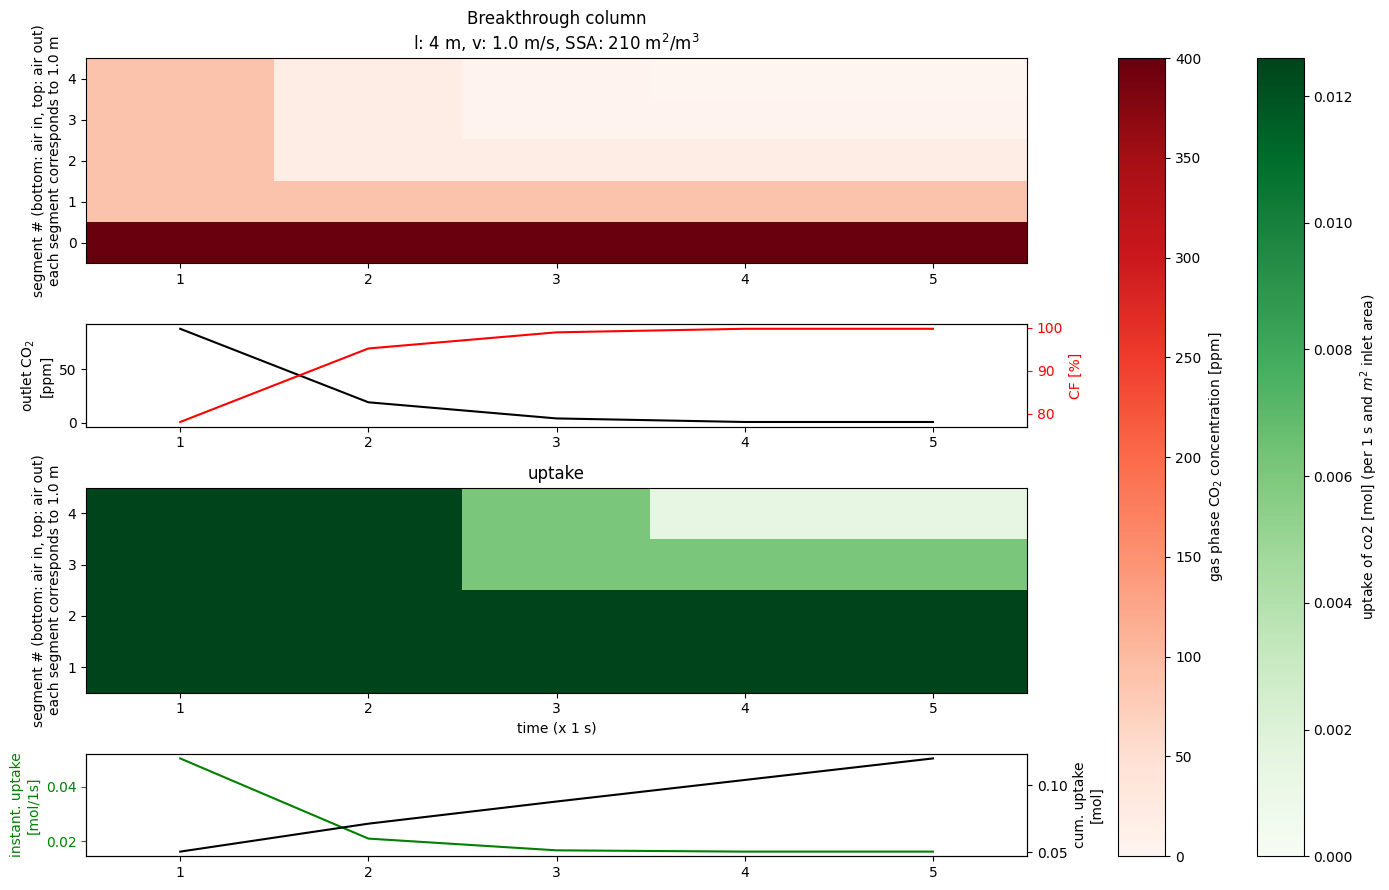

In [16]:


# Custom colormap
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])

# --- Figure with GridSpec: 3 rows, 2 cols ---
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(4, 3, width_ratios=[20, 1, 1], height_ratios=[2, 1, 2, 1])

ax1 = fig.add_subplot(gs[0, 0])          # full heatmap
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # outlet profile
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # tail heatmap
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)  # tail heatmap
cax = fig.add_subplot(gs[:, 1])          # colorbar (shared)
cax2 = fig.add_subplot(gs[:, 2])          # colorbar uptake (shared)

# --- Top: full heatmap ---
im = ax1.imshow(
    x[:,:].T * 10, 
    cmap="Reds", vmin=0, vmax=400,
    interpolation="nearest", origin="lower", aspect="auto",

)
ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
ax1.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
               f"each segment corresponds to {l_N} m")
ax1.set_xticks(np.arange(x.shape[0]))                       # ticks at 0..N-1
ax1.set_xticklabels(np.arange(1, x.shape[0] + 1))           # labels 1..N

# --- Middle: outlet + CF ---
line1, = ax2.plot(x[:, -1]*10, color="black", label="outlet CO$_2$")
ax2.set_ylabel("outlet CO$_2$\n[ppm]", color="black")

ax2b = ax2.twinx()
cf = (400 - x[:, -1]*10) / 4
line2, = ax2b.plot(cf, color="red", label="CF")
ax2b.set_ylabel("CF [%]", color="red")

ax2.tick_params(axis='y', colors=line1.get_color())
ax2b.tick_params(axis='y', colors=line2.get_color())

# --- Bottom middle: tail heatmap ---
im2 = ax3.imshow(
    n2l[:, :].T * 10,
    cmap="Greens", vmin=0, vmax=n2l.max(),
    interpolation="nearest", origin="lower", aspect="auto"
)
ax3.set_title(f"uptake")
ax3.set_xlabel(f"time (x {dt} s)")
ax3.set_ylabel(f"tail section (segment {p} onward)\n{l_N} m each")
ax3.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
               f"each segment corresponds to {l_N} m")
ax3.set_yticks(np.arange(n2l.shape[1]))                       # ticks at 0..N-1
ax3.set_yticklabels(np.arange(1, n2l.shape[1] + 1))           # labels 1..N

line3, = ax4.plot(np.sum(n2l, axis=1), color="green", label="outlet CO$_2$")
ax4.set_ylabel(f"instant. uptake\n[mol/{dt}s]", color="green")

ax4b = ax4.twinx()
n_total = integrated = np.cumsum(np.sum(n2l, axis=1))
line4, = ax4b.plot(n_total, color="black", label="cum. uptake")
ax4b.set_ylabel("cum. uptake\n[mol]", color="black")
#
ax4.tick_params(axis='y', colors=line3.get_color())
ax4b.tick_params(axis='y', colors=line4.get_color())

# --- Shared colorbar ---
fig.colorbar(im, cax=cax, label=f"gas phase CO$_2$ concentration [ppm]")
fig.colorbar(im2, cax=cax2, label=f"uptake of co2 [mol] (per {dt} s and $m^2$ inlet area)")

plt.tight_layout()
plt.show()


In [17]:
n2l

array([[0.0126    , 0.0126    , 0.0126    , 0.0126    ],
       [0.0126    , 0.00276652, 0.00276652, 0.00276652],
       [0.0126    , 0.00276652, 0.00060743, 0.00060743],
       [0.0126    , 0.00276652, 0.00060743, 0.00013337],
       [0.0126    , 0.00276652, 0.00060743, 0.00013337]])

In [18]:
np.sum(n2l, axis=1)

array([0.0504    , 0.02089955, 0.01658138, 0.01610732, 0.01610732])

In [19]:
int(1.8)

1

In [ ]:
n[t, :] * 8.314 * 298 / (V_N) #

array([nan, nan, nan, nan])

In [ ]:
n

array([[0.0126, 0.0126, 0.0126, 0.0126],
       [   nan,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan]])

In [ ]:
range(0, T)[T-1]

4